In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [2]:
df = pd.read_csv("../../../../main/sub_data/single_variant/inter-linear/train/train_inter-linear.csv",index_col="Date",parse_dates=True)
df_test = pd.read_csv("../../../../main/sub_data/single_variant/inter-linear/test/test_inter-linear.csv",index_col="Date",parse_dates=True)

## Transforming Data
    
    The Steps adopted for Transformation are
<ul>
    <li>Rolling Window</li>
    <li>Outliers Replacement</li>
</ul>

In [3]:
# We use Aggregate method (for this, we need a function)
def percent_change(series):
    prev = series[:-1]
    last = series[-1:]
    change = (last-np.sum(prev))/np.sum(prev)
    return change

def replace_outliers(series):
    mean_diff = np.abs(series - np.mean(series))
    # Criteria for detecting outliers
    this_mask = mean_diff > (np.std(series) * 3)
    # replace it with median
    series[this_mask] = np.nanmedian(series)
    return series

## Creation of Rolling with 
<ul>
<li> 7 days </li>
<li> 30 days </li>
</ul>

In [4]:
'''
    Rolling : A rolling window of every size (n) is applied to every column
    After applying an n size NaN Values will be available
    
'''
df_per_ch_30  =  df.rolling(10).aggregate(percent_change).dropna()

## Full Analysis of 30 days

In [5]:
df_per_ch_30

,Max.Demand met during the day (MW)
Date,
2013-04-10,-0.879993
2013-04-11,-0.875218
2013-04-12,-0.878073
2013-04-13,-0.879480
2013-04-14,-0.893184
...,...
2023-04-26,-0.893719
2023-04-27,-0.887743
2023-04-28,-0.891511


In [6]:
day_shifts = np.arange(1, 31).astype(int)
shifted_data = {i : df_per_ch_30["Max.Demand met during the day (MW)"].shift(i) for i in day_shifts}
shifted_data = pd.DataFrame(shifted_data)

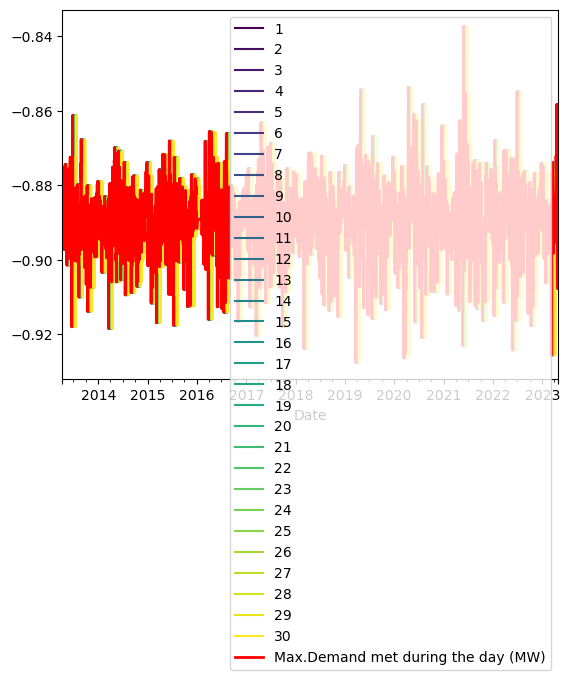

In [7]:
# Visualize it
ax = shifted_data.plot(cmap=plt.cm.viridis)
df_per_ch_30["Max.Demand met during the day (MW)"].plot(color='r', lw=2,ax=ax)
ax.legend(loc='best')
plt.show()

## Using Testing Data to calculate the MAPE scores

In [8]:
X = shifted_data.dropna()
y = df.loc['2013-05-10':]
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

In [9]:
# Fit the Ridge model
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
MAPE(y_test,y_pred)

0.1853059666501433

In [10]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
MAPE(y_test,y_pred)

0.17511125018621587

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
MAPE(y_pred,y_test)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.13370116671791796

In [12]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svr = SVR()
svr.fit(X_train_scaled, y_train)
y_pred = svr.predict(X_test_scaled)
MAPE(y_test,y_pred)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.18352284408493974

## Including Date Features

In [13]:
shifted_data['day_of_week'] = shifted_data.index.day_of_week
shifted_data['month_of_year'] = shifted_data.index.month

In [14]:
X_train = shifted_data.dropna()
y_train = df.loc['2013-05-10':]
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

In [15]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_train.columns.astype(str)

In [16]:
# Fit the Ridge model
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
MAPE(y_test,y_pred)

0.1853059666501433

In [17]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
MAPE(y_test,y_pred)

0.17511125018621587

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
MAPE(y_pred,y_test)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.13367481851186358

In [19]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svr = SVR()
svr.fit(X_train_scaled, y_train)
y_pred = svr.predict(X_test_scaled)
MAPE(y_test,y_pred)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.18352284408493974

## Without Transformation

In [20]:
day_shifts = np.arange(1, 31).astype(int)
shifted_data_no = {i : df["Max.Demand met during the day (MW)"].shift(i) for i in day_shifts}
shifted_data_no = pd.DataFrame(shifted_data_no)

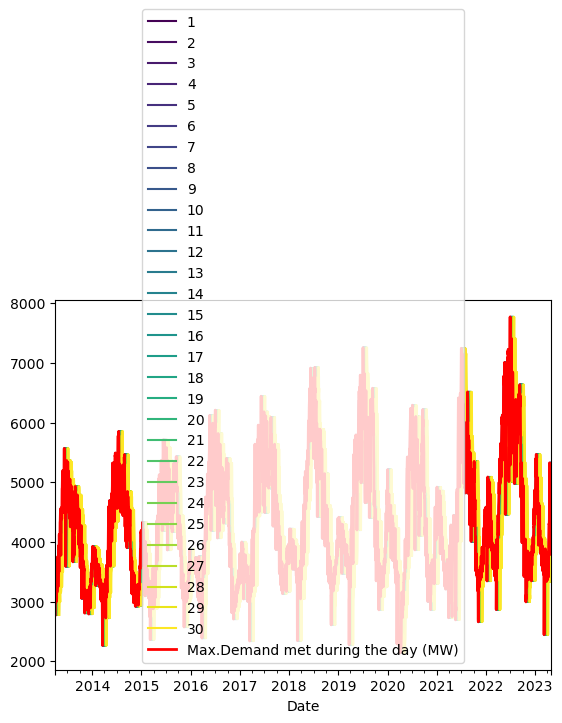

In [21]:
# Visualize it
ax = shifted_data_no.plot(cmap=plt.cm.viridis)
df["Max.Demand met during the day (MW)"].plot(color='r', lw=2,ax=ax)
ax.legend(loc='best')
plt.show()

In [22]:
X_no = shifted_data_no.dropna()
y_no = df.loc['2013-05-01':]
X_train_no,X_test_no,y_train_no,y_test_no = train_test_split(X,y,random_state=1)

In [23]:
# Fit the Ridge model
model = Ridge()
model.fit(X_train_no, y_train_no)
y_pred = model.predict(X_test_no)
MAPE(y_test_no,y_pred)

0.1853059666501433

In [24]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_no, y_train_no)
y_pred = lasso.predict(X_test_no)
MAPE(y_test_no,y_pred)

0.17511125018621587

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
gbm.fit(X_train_no, y_train_no)
y_pred = gbm.predict(X_test_no)
MAPE(y_pred,y_test_no)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.13358268027706466

In [26]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no)
X_test_scaled = scaler.transform(X_test_no)
svr = SVR()
svr.fit(X_train_scaled, y_train_no)
y_pred = svr.predict(X_test_scaled)
MAPE(y_test_no,y_pred)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.18352284408493974

## Including Date Features

In [27]:
shifted_data_no['day_of_week'] = shifted_data_no.index.day_of_week
shifted_data_no['month_of_year'] = shifted_data_no.index.month

In [28]:
X_no = shifted_data_no.dropna()
y_no = df.loc['2013-04-08':]
X_train_no,X_test_no,y_train_no,y_test_no = train_test_split(X,y,random_state=1)

In [29]:
X_train_no.columns = X_train_no.columns.astype(str)
X_test_no.columns = X_train_no.columns.astype(str)

In [30]:
# Fit the Ridge model
model = Ridge()
model.fit(X_train_no, y_train_no)
y_pred = model.predict(X_test_no)
MAPE(y_test_no,y_pred)

0.1853059666501433

In [31]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_no, y_train_no)
y_pred = lasso.predict(X_test_no)
MAPE(y_test_no,y_pred)

0.17511125018621587

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
gbm.fit(X_train_no, y_train_no)
y_pred = gbm.predict(X_test_no)
MAPE(y_pred,y_test_no)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.13355111639409464

In [33]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no)
X_test_scaled = scaler.transform(X_test_no)
svr = SVR()
svr.fit(X_train_scaled, y_train_no)
y_pred = svr.predict(X_test_scaled)
MAPE(y_test_no,y_pred)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.18352284408493974